# Notebook to demonstrate some basic PyTorch usage, where a simple network is trained to extract two original images from the average of them.
#### Author: Jakob Wadman

##### Each original image consists of a single circle where its size and position are varied. An input to the model then consists of the average of two such images, and the model is tasked with predicting the two corresponding original images.

##### The loss function approach is flexible so the approach would work for any type of original images. The approach with circles was just chosen for this demo so that there would be a clear correct answer for an average image (since for general images, there could be several plausible pairs of images that would result in the same average image).

In [ ]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(17)
random.seed(17)

### Functions for generating dataset images


In [ ]:
def generate_image_containing_a_cirle(
    image_side_length,
    circle_radius,
    circle_line_width,
    cirlcle_center_x,
    cirlcle_center_y,
):
    y, x = torch.meshgrid(
        torch.arange(image_side_length), torch.arange(image_side_length), indexing="ij"
    )

    distance = torch.sqrt((x - cirlcle_center_x) ** 2 + (y - cirlcle_center_y) ** 2)

    circle = (
        (distance >= circle_radius - circle_line_width / 2)
        & (distance <= circle_radius + circle_line_width / 2)
    ).float()

    # Add channel dimension
    return circle.unsqueeze(0)

In [ ]:
def generate_batch_of_images_containing_a_cirle(batch_size, image_side_length):
    batch = torch.zeros((batch_size, 1, image_side_length, image_side_length))
    for i in range(batch_size):
        circle_line_width = 3
        circle_radius = random.uniform(circle_line_width * 4, image_side_length // 2)
        circle_center_x = random.randint(0, image_side_length - 1)
        circle_center_y = random.randint(0, image_side_length - 1)
        batch[i] = generate_image_containing_a_cirle(
            image_side_length,
            circle_radius,
            circle_line_width,
            circle_center_x,
            circle_center_y,
        )

    return batch

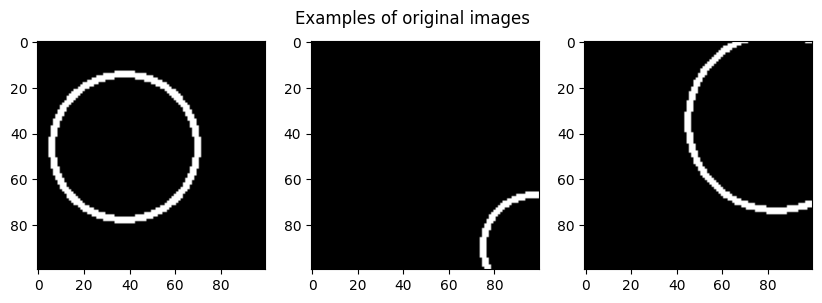

In [ ]:
f1, axes = plt.subplots(1, 3, figsize=(10, 3))

example_images = generate_batch_of_images_containing_a_cirle(
    batch_size=3, image_side_length=100
)
f1.suptitle("Examples of original images")
axes[0].imshow(example_images[0].squeeze(), cmap="gray")
axes[1].imshow(example_images[1].squeeze(), cmap="gray")
axes[2].imshow(example_images[2].squeeze(), cmap="gray")
plt.show()

### Defining network architecture
#### A encoder-decoder architecture was chosen. CNN layers are used for encoding the information into relevant features and two fully connected layers take care of the decoding.

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        # Encoder (having the same number of channels for each layer maybe doesn't make too much sense
        # but it works well enough for this problem at least).
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(7 * 7 * 256, 7 * 7 * 256),
            nn.BatchNorm1d(7 * 7 * 256),
            nn.ReLU(),
            nn.Linear(7 * 7 * 256, 2 * 100 * 100),
            nn.Sigmoid(),  # Ensure output is between 0 and 1
        )

    def forward(self, x):
        b, c, w, h = x.size()
        x = self.encoder(x)
        x = self.decoder(x.view(b, 7 * 7 * 256))
        # For each input image (i.e. average image) two images are predicted.
        return x.view(2 * b, c, w, h)

In [ ]:
model = Network().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
def generate_average_image_batch(image_batch):
    batch_size = image_batch.size()[0]
    assert batch_size % 2 == 0
    reshaped_images = image_batch.view(batch_size // 2, 2, *image_batch.size()[1:])
    average_image_batch = torch.mean(reshaped_images, dim=1)

    return average_image_batch

#### The loss function was chosen as the MSE error of the two input images and the two output images. Or rather, two MSE errors are calculated (one for each combination of input and output images) and the loss is chosen as the minimum of these two. A minimum-function is not strictly speaking differentialbe, but is differentiable in most of its domain, so it can still be used in the graph (e.g. I guess sort of the same reason as to why ReLU can be used).

In [ ]:
def loss_function(predicted_images_batch, original_images_batch):
    assert predicted_images_batch.size() == original_images_batch.size()
    batch_size = predicted_images_batch.size()[0]
    assert batch_size % 2 == 0
    loss_array = torch.zeros((batch_size // 2, 2), device=device)
    for i in range(loss_array.size()[0]):
        predicted_arrangement_1 = predicted_images_batch[[2 * i, (2 * i) + 1]]
        predicted_arrangement_2 = predicted_images_batch[[(2 * i) + 1, 2 * i]]
        loss_array[i, 0] = nn.MSELoss()(
            predicted_arrangement_1, original_images_batch[[2 * i, (2 * i) + 1]]
        )
        loss_array[i, 1] = nn.MSELoss()(
            predicted_arrangement_2, original_images_batch[[2 * i, (2 * i) + 1]]
        )

    return torch.mean(loss_array.min(dim=1).values)

In [ ]:
def generate_validation_loss(model, validation_original_images):
    assert model.training == False
    assert torch.is_grad_enabled() == False

    average_image_batch = generate_average_image_batch(validation_original_images)
    predicted_original_images = model(average_image_batch.to(device))

    validation_loss = loss_function(
        predicted_original_images, validation_original_images.to(device)
    )

    return validation_loss.item()

In [ ]:
image_side_length = 100
validation_original_images = generate_batch_of_images_containing_a_cirle(
    batch_size=1000, image_side_length=image_side_length
)

In [ ]:
model.train()
batch_size = 32
num_batches_to_train_on = 300000
training_loss_list = []
validation_loss_list = []

for batch_index in range(num_batches_to_train_on):
    # Since there are two original images per average image, twice the batch size is used here
    original_images_batch = generate_batch_of_images_containing_a_cirle(
        batch_size=2 * batch_size, image_side_length=100
    )

    average_image_batch = generate_average_image_batch(original_images_batch)

    predicted_images_batch = model(average_image_batch.to(device))

    optimizer.zero_grad()
    loss = loss_function(predicted_images_batch, original_images_batch.to(device))
    loss.backward()
    optimizer.step()

    training_loss_list.append(loss.item())

    if batch_index % 300 == 0:
        model.eval()
        with torch.no_grad():
            validation_loss = generate_validation_loss(
                model, validation_original_images
            )
        model.train()
        validation_loss_list.append(validation_loss)
        print(
            f"Validation loss at training batch iteration {batch_index + 1} out of {num_batches_to_train_on}: {validation_loss_list[-1]}"
        )

### Evaluation
#### The performance of the trained network is compared to a model that just outputs two copies of the input average image. There's a clear improvement using the model compared to just outputing the input image.

In [ ]:
class ModelForThatJustReturnsTwoCopiesOfTheInputImage(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input_image_batch):
        return input_image_batch.repeat(1, 2, 1, 1).view(
            2 * input_image_batch.size()[0],
            input_image_batch.size()[1],
            *input_image_batch.size()[2:],
        )


model_that_just_returns_two_copies_of_the_input_image = (
    ModelForThatJustReturnsTwoCopiesOfTheInputImage().eval()
)
with torch.no_grad():
    validation_loss_reference = generate_validation_loss(
        model_that_just_returns_two_copies_of_the_input_image,
        validation_original_images,
    )

print(f"Final validation loss: {validation_loss_list[-1]}")
print(
    f"Loss for model that just returns two copies of the average image: {validation_loss_reference}"
)
quota = validation_loss_list[-1] / validation_loss_reference
print(
    f"Quota of final loss and loss when just returning two copies of the average image: {round(quota, 3)}"
)

Final validation loss: 0.0018076037522405386
Loss for model that just returns two copies of the average image: 0.01696605049073696
Quota of final loss and loss when just returning two copies of the average image: 0.107


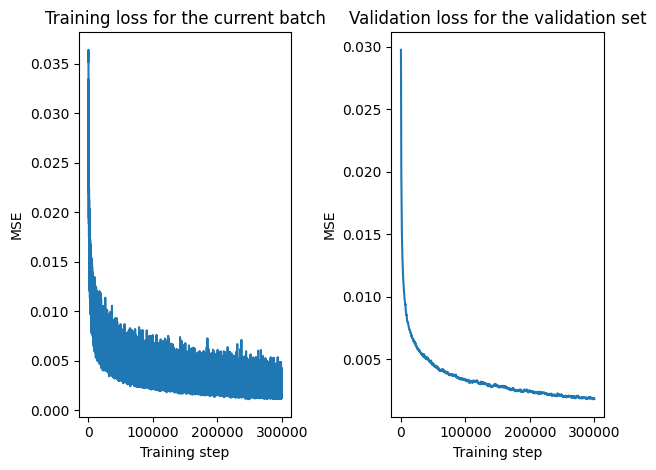

In [ ]:
training_epoch_indicies = np.linspace(
    0, num_batches_to_train_on, len(training_loss_list)
)
validation_epoch_indicies = np.linspace(
    0, num_batches_to_train_on, len(validation_loss_list)
)
f2, (ax_training, ax_validation) = plt.subplots(1, 2)

ax_training.plot(training_epoch_indicies[100:], training_loss_list[100:])
ax_training.set_title("Training loss for the current batch")
ax_training.set_xlabel("Training step")
ax_training.set_ylabel("MSE")

ax_validation.plot(validation_epoch_indicies[1:], validation_loss_list[1:])
ax_validation.set_title("Validation loss for the validation set")
ax_validation.set_xlabel("Training step")
ax_validation.set_ylabel("MSE")

f2.tight_layout()
plt.show()

### Some input and output examples

#### **Note:** The order of the predicted images does not necessarily match the order of the input images.

#### The network manages to predict the original images. Based on the plots above of the loss values, it's probable that training the network for a longer duration would result in even better results.

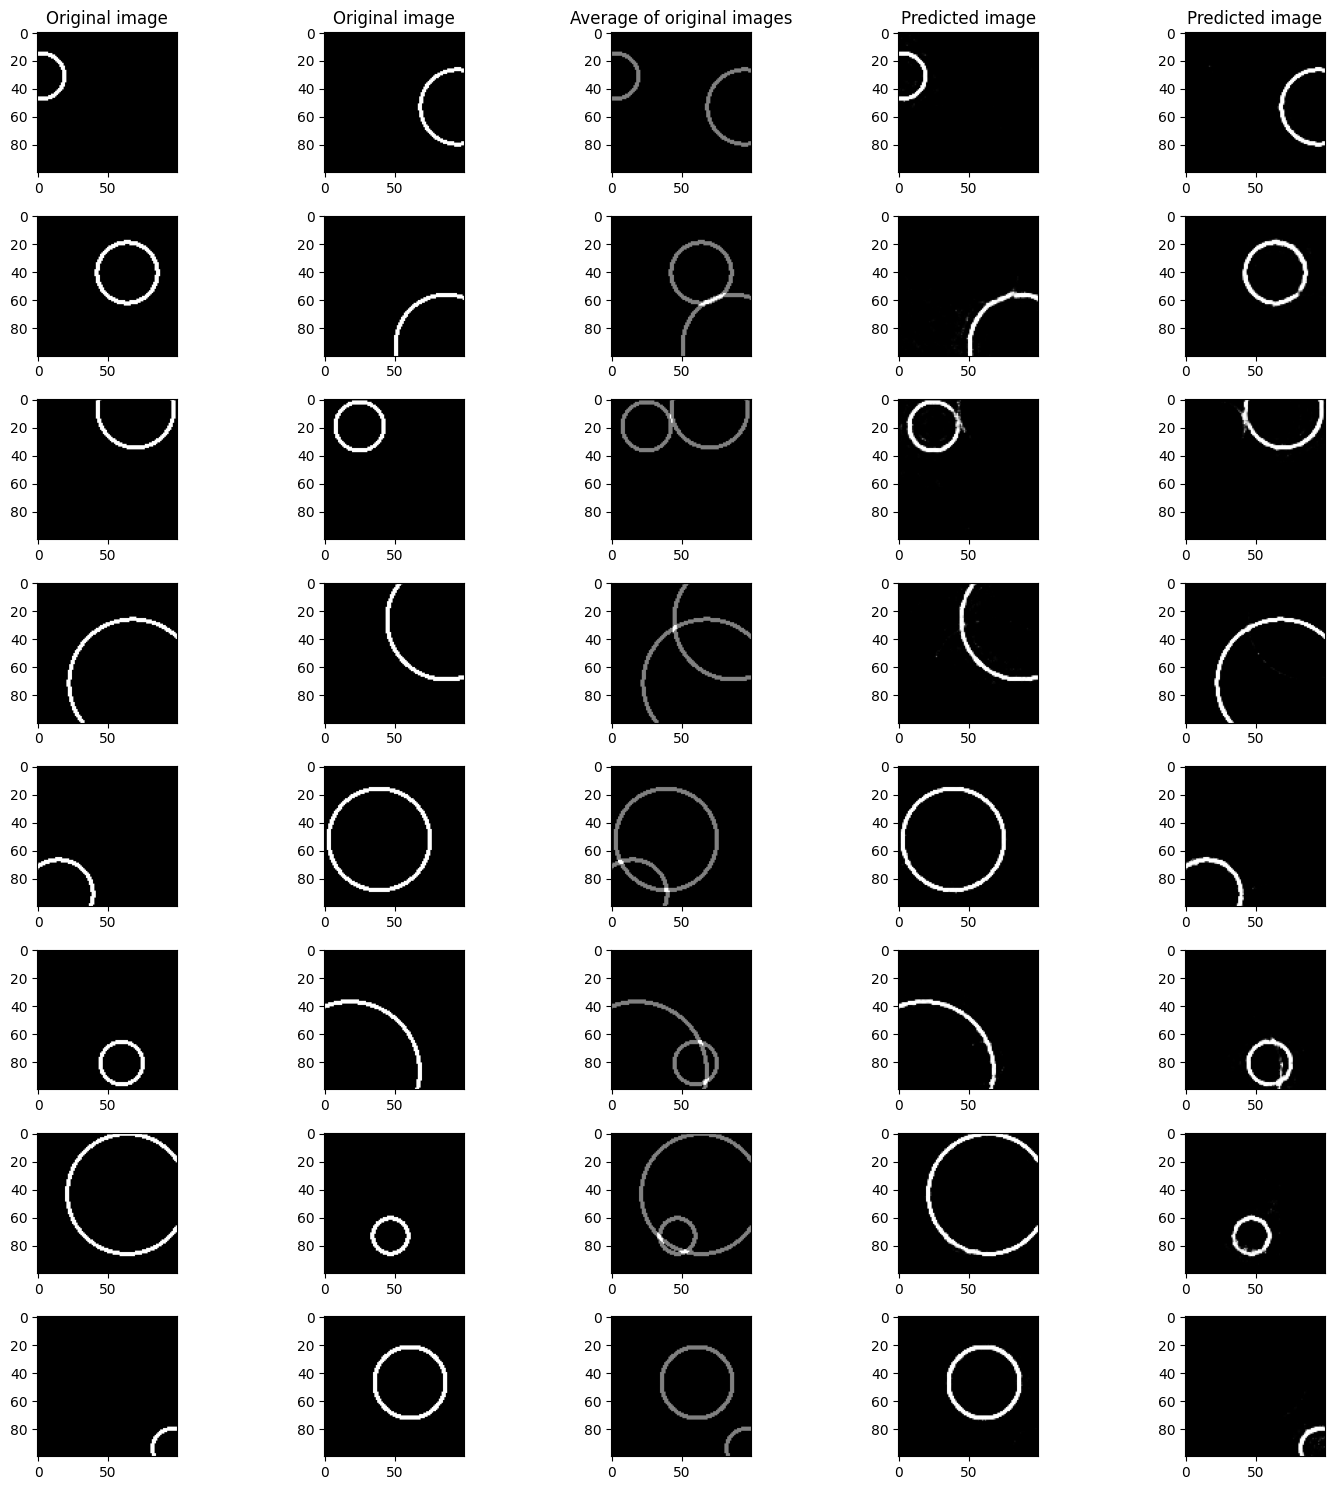

In [ ]:
f3, axes = plt.subplots(8, 5, figsize=(15, 15))
num_axes_cols = axes.shape[1]
axes = axes.ravel()
axes[0].set_title("Original image")
axes[1].set_title("Original image")
axes[2].set_title("Average of original images")
axes[3].set_title("Predicted image")
axes[4].set_title("Predicted image")

model.eval()
with torch.no_grad():
    for i in range(len(axes) // num_axes_cols):
        original_image_1 = validation_original_images[2 * i].unsqueeze(0)
        original_image_2 = validation_original_images[(2 * i) + 1].unsqueeze(0)

        average_image = generate_average_image_batch(
            torch.cat((original_image_1, original_image_2), dim=0)
        )
        average_image_device = average_image.to(device)

        predicted_original_images = model(average_image_device)

        axes[num_axes_cols * i].imshow(
            original_image_1.squeeze(), cmap="gray", vmin=0.0, vmax=1.0
        )
        axes[(num_axes_cols * i) + 1].imshow(
            original_image_2.squeeze(), cmap="gray", vmin=0.0, vmax=1.0
        )
        axes[(num_axes_cols * i) + 2].imshow(
            average_image.squeeze(), cmap="gray", vmin=0.0, vmax=1.0
        )
        axes[(num_axes_cols * i) + 3].imshow(
            predicted_original_images[0].squeeze().cpu(),
            cmap="gray",
            vmin=0.0,
            vmax=1.0,
        )
        axes[(num_axes_cols * i) + 4].imshow(
            predicted_original_images[1].squeeze().cpu(),
            cmap="gray",
            vmin=0.0,
            vmax=1.0,
        )
f3.tight_layout()
plt.show()